# Digital Processing of Remote Sensing Images
### Teachers:
  - Dr. Thales Körting
  - Dra. Leila Fonseca
  - Dr. Emiliano
  - Dr. Rennan
  ...

### Students:
  - Alisson Ribeiro
  - Cesar Augusto de Moraes Costa
  - Érick Rodrigues

version: 1.0.0

date: 03/08/2022


# Introduction


  - This notebook has been cloned from [remotesensinginfo](https://github.com/remotesensinginfo/rsgislib-tutorials) and is being modified to conform to 3-band images from the CBERS 04A MUX sensor satellite.



​

This notebook will go through the steps to undertake a classification using a segmentation rather than a pixel based classification. 

​

A number of studies have proposed that segmenting an image and classifying the segments can produce a better classification result than classifying individual pixels.

​

The notebook will go through the following steps:

​

 * Perform segmentation

 * Populate segments with data

 * Extract sample data

 * Split sample data into training, testing and validation sets

 * Training Classifier

 * Apply Classifier

​



## Running Notebook

The notebook has been run and saved with the outputs so you can see what the outputs should be and so the notebook and be browsed online without having to run the notebook for it to make sense. 

If you are running the notebook for yourself it is recommended that you clear the existing outputs which can be done by running one of the following options depending on what system you are using:

**Jupyter-lab**:

> \> _Edit_ \> _'Clear All Outputs'_

**Jupyter-notebook**:

> \> _Cell_ \> _'All Outputs'_ \> _Clear_


In [1]:
from platform import python_version

print(python_version())

3.10.5


# 1. Import the modules needed

In [5]:
# !pip install --upgrade pip
# !pip install pillow
# !pip install geopandas
# !pip install matplotlib

In [26]:
!pip freeze

argon2-cffi @ file:///home/conda/feedstock_root/build_artifacts/argon2-cffi_1640817743617/work
argon2-cffi-bindings @ file:///home/conda/feedstock_root/build_artifacts/argon2-cffi-bindings_1649500328244/work
asttokens==2.0.5
attrs @ file:///home/conda/feedstock_root/build_artifacts/attrs_1659291887007/work
backcall==0.2.0
backports.functools-lru-cache @ file:///home/conda/feedstock_root/build_artifacts/backports.functools_lru_cache_1618230623929/work
beautifulsoup4 @ file:///home/conda/feedstock_root/build_artifacts/beautifulsoup4_1649463573192/work
bleach @ file:///home/conda/feedstock_root/build_artifacts/bleach_1656355450470/work
cached-property @ file:///home/conda/feedstock_root/build_artifacts/cached_property_1615209429212/work
certifi==2022.6.15
cffi @ file:///home/conda/feedstock_root/build_artifacts/cffi_1656782834004/work
click==8.1.3
click-plugins==1.1.1
cligj==0.7.2
colorama @ file:///home/conda/feedstock_root/build_artifacts/colorama_1655412516417/work
cycler==0.11.0
debug

In [10]:
# Import modules from python standard library
import os
import pprint
import random

# Import the matplotlib plotting module and set it to work within
# a notebook environment.
%matplotlib inline
import matplotlib
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

# Import the RSGISLib modules for the notebook
import rsgislib
from rsgislib.segmentation import shepherdseg
import rsgislib.classification
import rsgislib.classification.classsklearn
import rsgislib.classification.classratutils
import rsgislib.tools.filetools
import rsgislib.tools.plotting
import rsgislib.vectorutils
import rsgislib.zonalstats
import rsgislib.rastergis
import rsgislib.vectorutils.createrasters
from sklearn.ensemble import RandomForestClassifier

# Import the geopandas module
import geopandas

# Import the numpy module
import numpy

# scikit-learn imports
from sklearn.model_selection import GridSearchCV

# 2. Define the input image

In [2]:
# Input Sentinel-2 image file with 20 m resolution pixels.  # MUX
input_img = "/home/cesar/Curso_GEOBIA/areas_estudo_mux_2021_p10.tif"

img_band_info = list()
img_band_info.append(
    rsgislib.imageutils.ImageBandInfo(
        file_name=input_img, name="sen2", bands=[1, 2, 3]
    )
)

# 3. Perform Segmentation

This segmentation is trying to group neighbouring pixels which are of the same class together in an unsupervised process to simplify and improve following classification steps. In some cases these kind of segments (also referred to as clumps) can be referred to as 'super-pixels' (i.e., larger grouping of image pixels with similar properties.

One advantage of having a group of pixels is that is allows some statistic properties of groups (e.g., standard deviation) to be calculated alongside a simple mean which can be useful when trying to classify classes which have a changing texture of time, for example.

However, you should also bear in mind that the boundaries drawn by the segmentation will then be the boundaries within final map so any errors within the segmentation might be brought through into the classification result.


In [3]:
clumps_img = "sen2_20180629_aber_segs.kea"
tmp_dir = "tmp"

shepherdseg.run_shepherd_segmentation(
    input_img,
    clumps_img,
    None,
    tmp_dir,
    gdalformat="KEA", # Output file format
    calc_stats=True,  # Calculate statistics on the output images
    no_stretch=False, # Normalise the input bands by applying a 2 standard devation stretch
    no_delete=False,  # Delete the temporary files created during the processing
    num_clusters=60,  # The number of clusters (k) for the initial kMeans clustering
    min_n_pxls=50,    # Minimum number of pixels within a clump (segment)
    dist_thres=100,
    bands=[1, 2, 3],  # Just use bands 8 (NIR), 9 (SWIR) and 3 (Red)
    sampling=100,     # Speed up the kMeans clustering by only using every 100th pixel.
    km_max_iter=200,  # Maximum number of kMeans iterations
    process_in_mem=True,  # Do the process using in-memory datasets rather than to disk
    save_process_stats=False,
    img_stretch_stats="",
    kmeans_centres="",
    img_stats_json_file="",
)

Subsetting the image bands
New image width = 1000 height = 1000 bands = 3
Stretch Input Image
Add 1 to stretched file to ensure there are no all zeros (i.e., no data) regions created.
Create Input Image Mask.



Band[1] Min = 29 Mean = 36.00463 (Std Dev = 3.77663402555) max = 166
Band[2] Min = 19 Mean = 29.368127 (Std Dev = 5.03003573663) max = 154
Band[3] Min = 9 Mean = 16.354509 (Std Dev = 5.55984355614) max = 133
New image width = 1000 height = 1000 bands = 3

New image width = 1000 height = 1000 bands = 3

Image: tmp/areas_estudo_mux_2021_p10_bselect.kea
	 Variable 'b1' is band 1
New image width = 1000 height = 1000 bands = 1

Mask stretched Image.
Deleting file: tmp/areas_estudo_mux_2021_p10_stchdonly.kea
New image width = 1000 height = 1000 bands = 3

Deleting file: tmp/areas_estudo_mux_2021_p10_stchdonly_off.kea
Deleting file: tmp/areas_estudo_mux_2021_p10_stchdmaskonly.kea
Performing KMeans.
inputImage = tmp/areas_estudo_mux_2021_p10_stchd.kea
Apply KMeans to image.
Eliminate S

# 4. Create Vector Polygons for the Clumps

While the raster clumps provide an efficient way of storing and processing the segments when visualising the segments within a GIS having a raster version can also be helpful. The command below show how to vectorise the segments to a vector layer. You will probably find it useful to open the layer produced, alongside the input image, with QGIS to visualise the segmentation. 

While raster clumps are efficient when dealing with raster data of the same spatial resolution as the clump pixels, when dealing with data at very different resolutions (e.g., segments from landsat intersecting with MODIS pixels) it can also be useful to use a vector and zonal statistics for further data analysis where the raster datasets do not have to be resampled to the same resolution as the raster clumps.


In [4]:
import rsgislib.vectorutils.createvectors

segs_vec_file = "sen2_20180629_aber_segs.gpkg"
segs_vec_lyr = "sen2_20180629_aber_segs"

rsgislib.vectorutils.createvectors.polygonise_raster_to_vec_lyr(
    out_vec_file=segs_vec_file,   # The output vector file name and path
    out_vec_lyr=segs_vec_lyr,     # The output vector layer name
    out_format="GPKG",            # The output vector format
    input_img=clumps_img,         # The input segmentation image
    img_band=1,                   # The band within the input image
    mask_img=clumps_img,          # A mask image (usually the same as the input image)
    mask_band=1,                  # The band within the mask image
)

 16%|██████▌                                  | 16/100 [00:00<00:00, 141.13it/s]

Polygonising...


101it [00:02, 48.52it/s]                                                        

Completed


# 5. Visualise Segmentation

Image Data Size: 1000 x 1000


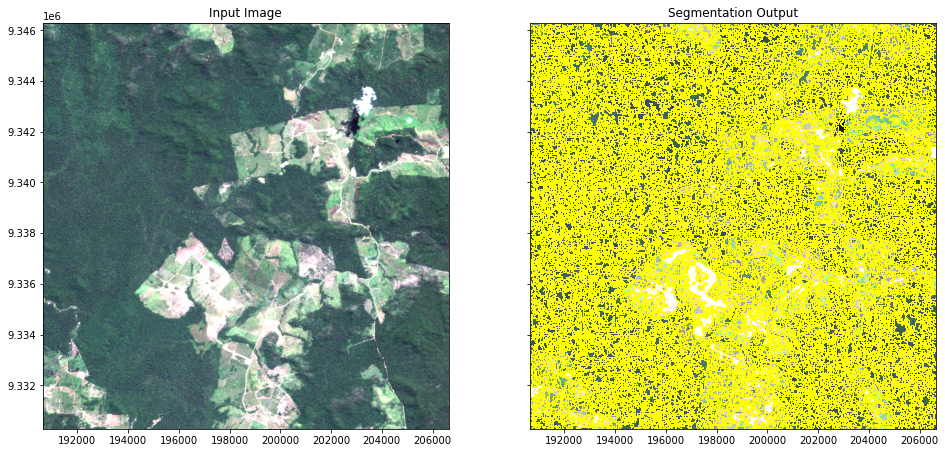

In [18]:
# Define a bbox for the subset to be displayed
sub_img_bbox = [190640.0000000000000000,9330288.0000000000000000,206640.0000000000000000,9346288.0000000000000000]
# Subset bbox reformated for geopandas
gp_img_bbox = [sub_img_bbox[0], sub_img_bbox[2], sub_img_bbox[1], sub_img_bbox[3]]

# Use geopandas to read the vector layer
segs_gdf = geopandas.read_file(segs_vec_file, layer=segs_vec_lyr, bbox=gp_img_bbox)

### Input image
# Get the image data as a numpy array and the spatial bounding
# box of the image data. We have specified that the bands we
# want for the visualisation are 8, 9, 3 (NIR, SWIR1, Red)
# which produces a good false colour visualisation which is
# good at picking out vegetation. If you want a true colour
# (i.e., Red, Green, Blue) visualisation change the bands to
# [3, 2, 1]
img_data, img_coords = rsgislib.tools.plotting.get_gdal_raster_mpl_imshow(
    input_img, bands=[3, 2, 1], bbox=sub_img_bbox,
)

# Stretch the image data so is visualises appropriately and usefully
# In this case the resulting values will be between 0-1.
img_data_strch = rsgislib.tools.plotting.stdev_stretch_np_arr(img_data, no_data_val=0.0)

# Create the matplotlib figure - in this case two plots so the NDVI
# and image are plotted alongside each other
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), sharey=True)

# Use the imshow function to display the image data within the plot
# the extent option defines the x and y axis values.
ax1.imshow(img_data_strch, extent=img_coords)
ax1.title.set_text("Input Image")

# Plot the polygons with no face colour and an edge colour of yellow. 
# i.e., just the polygon outlines in yellow.
segs_gdf.plot(ax=ax2, facecolor="none", edgecolor="yellow")
ax2.imshow(img_data_strch, extent=img_coords)
ax2.title.set_text("Segmentation Output")


# 6. Populate Clumps

## 6.1 Populate Sentinel-2 Reflectance Data

In this case we are populating the raster clumps with just the mean reflectance values from the Sentinel-2 data.


In [19]:
bs = []
bs.append(rsgislib.rastergis.BandAttStats(band=1,  mean_field='blue_refl'))
bs.append(rsgislib.rastergis.BandAttStats(band=2,  mean_field='green_refl'))
bs.append(rsgislib.rastergis.BandAttStats(band=3,  mean_field='red_refl'))
# bs.append(rsgislib.rastergis.BandAttStats(band=4,  mean_field='re_b5_refl'))
# bs.append(rsgislib.rastergis.BandAttStats(band=5,  mean_field='re_b6_refl'))
# bs.append(rsgislib.rastergis.BandAttStats(band=6,  mean_field='re_b7_refl'))
# bs.append(rsgislib.rastergis.BandAttStats(band=7,  mean_field='nir_b8_refl'))
# bs.append(rsgislib.rastergis.BandAttStats(band=8,  mean_field='nir_b8a_refl'))
# bs.append(rsgislib.rastergis.BandAttStats(band=9,  mean_field='swir1_refl'))
# bs.append(rsgislib.rastergis.BandAttStats(band=10, mean_field='swir2_refl'))
rsgislib.rastergis.populate_rat_with_stats(input_img, clumps_img, bs)

## 6.2 Populate Training Data

To add the vector training samples to the clumps the vector layers need to be rasterised and then the mode (as it is thematic data) of the training regions added to the clumps. In this case, the function `populate_clumps_with_class_training` will do this analysis for us for all the classes using the information defined from the list of `ClassVecSamplesInfoObj` objects.

In [28]:
# Create Training Rasterise tmp directory
tmp_train_dir = "train_tmp"
if not os.path.exists(tmp_train_dir):
    os.mkdir(tmp_train_dir)

vec_train_file = "/home/cesar/Curso_GEOBIA/cbers_mux_samples.gpkg"

# Define Training Data
class_vec_sample_clumps_info = list()

# Define the file name of the samples HDF5 file, which will be created
cbers_mux_samples_sombra_clumps_h5 = "cbers_mux_samples_sombra_smpls_clumps.h5"
class_vec_sample_clumps_info.append(
    rsgislib.classification.ClassVecSamplesInfoObj(
        id=1,
        class_name="cbers_mux_samples_sombra",
        vec_file=vec_train_file,
        vec_lyr="cbers_mux_samples_Sombra",
        file_h5=cbers_mux_samples_sombra_clumps_h5,
    )
)

# Define the file name of the samples HDF5 file, which will be created
cbers_mux_samples_nuvem_clumps_h5 = "cbers_mux_samples_nuvem_smpls_clumps.h5"
class_vec_sample_clumps_info.append(
    rsgislib.classification.ClassVecSamplesInfoObj(
        id=2,
        class_name="cbers_mux_samples_nuvem",
        vec_file=vec_train_file,
        vec_lyr="cbers_mux_samples_Nuvem",
        file_h5=cbers_mux_samples_nuvem_clumps_h5,
    )
)


# Define the file name of the samples HDF5 file, which will be created
cbers_mux_samples_mata_clumps_h5 = "cbers_mux_samples_mata_smpls_clumps.h5"
class_vec_sample_clumps_info.append(
    rsgislib.classification.ClassVecSamplesInfoObj(
        id=3,
        class_name="cbers_mux_samples_mata",
        vec_file=vec_train_file,
        vec_lyr="cbers_mux_samples_Mata",
        file_h5=cbers_mux_samples_mata_clumps_h5,
    )
)

# Define the file name of the samples HDF5 file, which will be created
cbers_mux_samples_estrada_clumps_h5 = "cbers_mux_samples_estrada_smpls_clumps.h5"
class_vec_sample_clumps_info.append(
    rsgislib.classification.ClassVecSamplesInfoObj(
        id=4,
        class_name="cbers_mux_samples_estrada",
        vec_file=vec_train_file,
        vec_lyr="cbers_mux_samples_Estrada",
        file_h5=cbers_mux_samples_estrada_clumps_h5,
    )
)

# # Define the file name of the samples HDF5 file, which will be created
# grass_long_clumps_h5 = "grass_long_smpls_clumps.h5"
# class_vec_sample_clumps_info.append(
#     rsgislib.classification.ClassVecSamplesInfoObj(
#         id=5,
#         class_name="grass_long",
#         vec_file=vec_train_file,
#         vec_lyr="Grass_Long",
#         file_h5=grass_long_clumps_h5,
#     )
# )

# # Define the file name of the samples HDF5 file, which will be created
# grass_short_clumps_h5 = "grass_short_smpls_clumps.h5"
# class_vec_sample_clumps_info.append(
#     rsgislib.classification.ClassVecSamplesInfoObj(
#         id=6,
#         class_name="grass_short",
#         vec_file=vec_train_file,
#         vec_lyr="Grass_Short",
#         file_h5=grass_short_clumps_h5,
#     )
# )

# # Define the file name of the samples HDF5 file, which will be created
# nonphoto_veg_clumps_h5 = "nonphoto_veg_smpls_clumps.h5"
# class_vec_sample_clumps_info.append(
#     rsgislib.classification.ClassVecSamplesInfoObj(
#         id=7,
#         class_name="nonphoto_veg",
#         vec_file=vec_train_file,
#         vec_lyr="NonPhotosynthetic_Vegetation",
#         file_h5=nonphoto_veg_clumps_h5,
#     )
# )

# # Define the file name of the samples HDF5 file, which will be created
# scrub_clumps_h5 = "scrub_smpls_clumps.h5"
# class_vec_sample_clumps_info.append(
#     rsgislib.classification.ClassVecSamplesInfoObj(
#         id=8,
#         class_name="scrub",
#         vec_file=vec_train_file,
#         vec_lyr="Scrub",
#         file_h5=scrub_clumps_h5,
#     )
# )

# # Define the file name of the samples HDF5 file, which will be created
# water_clumps_h5 = "water_smpls_clumps.h5"
# class_vec_sample_clumps_info.append(
#     rsgislib.classification.ClassVecSamplesInfoObj(
#         id=9,
#         class_name="water",
#         vec_file=vec_train_file,
#         vec_lyr="Water_Training",
#         file_h5=water_clumps_h5,
#     )
# )

# # Define the file name of the samples HDF5 file, which will be created
# bracken_clumps_h5 = "bracken_smpls_clumps.h5"
# class_vec_sample_clumps_info.append(
#     rsgislib.classification.ClassVecSamplesInfoObj(
#         id=10,
#         class_name="bracken",
#         vec_file=vec_train_file,
#         vec_lyr="Bracken",
#         file_h5=bracken_clumps_h5,
#     )
# )

rsgislib.classification.classratutils.populate_clumps_with_class_training(clumps_img, class_vec_sample_clumps_info, tmp_train_dir, classes_int_col="class_int_smpls", classes_name_col="class_name_smpls")

Creating output image using input image

Running Rasterise now...
Creating output image using input image
Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.


Running Rasterise now...
Get Image Min and Max.

Creating output image using input image
Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.


Running Rasterise now...
Creating output image using input image
Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.


Running Rasterise now...
Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.

New image width = 1000 height = 1000 bands = 1

Opening Clumps Image: sen2_20180629_aber_segs.kea
Opening Input Image: train_tmp/CombinedClasses_ac8452f643.kea


Min 0
Max 4
Range 5
[0, 1, 2, 3, 4]

Deleting file: train_tmp/cbers_mux_samples_so

# 7. Extract Sample Data

## 7.1 Extract Clumps Sample Data

To train the classifier using the same function(s) as used for the per-pixel based classification we need to extract the samples to a HDF5 file. This also has the advantage that samples from multiple images can be extracted and merged to create the global training dataset. 


In [29]:
# Columns to be extracted and used for classification
cols = ["blue_refl", "green_refl", "red_refl"]
# Reading classification column from RAT.
class_int_smpls_col = rsgislib.rastergis.get_column_data(clumps_img, "class_int_smpls")
# Get the unique classes (i.e., there are samples for the class)
unq_classes = numpy.unique(class_int_smpls_col)

cls_smpls_clumps_info = dict()

# Loop through each of the classes to extract the samples to a HDF5
for class_vec_sample in class_vec_sample_clumps_info:
    print("{}:".format(class_vec_sample.class_name))
    # Check the class is within the list of unique classes
    if class_vec_sample.id in unq_classes:
        # Extract the class samples to a HDF5 file
        rsgislib.classification.classratutils.extract_rat_col_data(clumps_img, cols, "class_int_smpls", class_vec_sample.id, class_vec_sample.file_h5, datatype=rsgislib.TYPE_32FLOAT)
        cls_smpls_clumps_info[class_vec_sample.class_name] = rsgislib.classification.ClassSimpleInfoObj(id=class_vec_sample.id, file_h5=class_vec_sample.file_h5)


cbers_mux_samples_sombra:
n feats: 6
n cols: 3
cbers_mux_samples_nuvem:
n feats: 1
n cols: 3
cbers_mux_samples_mata:
n feats: 254
n cols: 3
cbers_mux_samples_estrada:
n feats: 14
n cols: 3



Note, the number of samples (i.e., 'n feats') is low (i.e., < 56) and this will produce a poor quality classification as samples will need to be split into training, testing and validation sets. The number of samples is low because the segments clumps a number of pixels together identifying regions which are (hopefully) the same class. Therefore, if a clump is 50 pixels then this would produce a single classification sample compared to 50 if the samples were extract from individual pixels.


## 7.2 Extract Pixel Sample Data

Therefore, to increase the number of samples classification samples can also be extracted for the image pixels, which will then be merged with the clump samples. However, this is only possible as the classification is only using the mean clump reflectance which is largely equivlent to the individual pixel reflectance. If you wished to use more features (e.g., standard deviation or shape measures) then these could only be calculated from the clumps and therefore adding the pixel values to the training would not be possible. 

The number of training samples is an important consideration when undertaking a segmentation based machine learning classification.


In [30]:
class_vec_sample_pixels_info = list()

# Define the file name of the samples HDF5 file, which will be created
cbers_mux_samples_sombra_pixels_h5 = "cbers_mux_samples_sombra_smpls_pixels.h5"
class_vec_sample_pixels_info.append(
    rsgislib.classification.ClassVecSamplesInfoObj(
        id=1,
        class_name="cbers_mux_samples_sombra",
        vec_file=vec_train_file,
        vec_lyr="cbers_mux_samples_Sombra",
        file_h5=cbers_mux_samples_sombra_pixels_h5,
    )
)

# Define the file name of the samples HDF5 file, which will be created
cbers_mux_samples_nuvem_pixels_h5 = "cbers_mux_samples_nuvem_smpls_pixels.h5"
class_vec_sample_pixels_info.append(
    rsgislib.classification.ClassVecSamplesInfoObj(
        id=2,
        class_name="cbers_mux_samples_nuvem",
        vec_file=vec_train_file,
        vec_lyr="cbers_mux_samples_Nuvem",
        file_h5=cbers_mux_samples_nuvem_pixels_h5,
    )
)


# Define the file name of the samples HDF5 file, which will be created
cbers_mux_samples_mata_pixels_h5 = "cbers_mux_samples_mata_smpls_pixels.h5"
class_vec_sample_pixels_info.append(
    rsgislib.classification.ClassVecSamplesInfoObj(
        id=3,
        class_name="cbers_mux_samples_mata",
        vec_file=vec_train_file,
        vec_lyr="cbers_mux_samples_Mata",
        file_h5=cbers_mux_samples_mata_pixels_h5,
    )
)

# Define the file name of the samples HDF5 file, which will be created
cbers_mux_samples_estrada_pixels_h5 = "cbers_mux_samples_estrada_smpls_pixels.h5"
class_vec_sample_pixels_info.append(
    rsgislib.classification.ClassVecSamplesInfoObj(
        id=4,
        class_name="cbers_mux_samples_estrada",
        vec_file=vec_train_file,
        vec_lyr="cbers_mux_samples_Estrada",
        file_h5=cbers_mux_samples_estrada_pixels_h5,
    )
)

# # Define the file name of the samples HDF5 file, which will be created
# grass_long_pixels_h5 = "grass_long_smpls_pixels.h5"
# class_vec_sample_pixels_info.append(
#     rsgislib.classification.ClassVecSamplesInfoObj(
#         id=5,
#         class_name="grass_long",
#         vec_file=vec_train_file,
#         vec_lyr="Grass_Long",
#         file_h5=grass_long_pixels_h5,
#     )
# )

# # Define the file name of the samples HDF5 file, which will be created
# grass_short_pixels_h5 = "grass_short_smpls_pixels.h5"
# class_vec_sample_pixels_info.append(
#     rsgislib.classification.ClassVecSamplesInfoObj(
#         id=6,
#         class_name="grass_short",
#         vec_file=vec_train_file,
#         vec_lyr="Grass_Short",
#         file_h5=grass_short_pixels_h5,
#     )
# )

# # Define the file name of the samples HDF5 file, which will be created
# nonphoto_veg_pixels_h5 = "nonphoto_veg_smpls_pixels.h5"
# class_vec_sample_pixels_info.append(
#     rsgislib.classification.ClassVecSamplesInfoObj(
#         id=7,
#         class_name="nonphoto_veg",
#         vec_file=vec_train_file,
#         vec_lyr="NonPhotosynthetic_Vegetation",
#         file_h5=nonphoto_veg_pixels_h5,
#     )
# )

# # Define the file name of the samples HDF5 file, which will be created
# scrub_pixels_h5 = "scrub_smpls_pixels.h5"
# class_vec_sample_pixels_info.append(
#     rsgislib.classification.ClassVecSamplesInfoObj(
#         id=8,
#         class_name="scrub",
#         vec_file=vec_train_file,
#         vec_lyr="Scrub",
#         file_h5=scrub_pixels_h5,
#     )
# )

# # Define the file name of the samples HDF5 file, which will be created
# water_pixels_h5 = "water_smpls_pixels.h5"
# class_vec_sample_pixels_info.append(
#     rsgislib.classification.ClassVecSamplesInfoObj(
#         id=9,
#         class_name="water",
#         vec_file=vec_train_file,
#         vec_lyr="Water_Training",
#         file_h5=water_pixels_h5,
#     )
# )

# # Define the file name of the samples HDF5 file, which will be created
# bracken_pixels_h5 = "bracken_smpls_pixels.h5"
# class_vec_sample_pixels_info.append(
#     rsgislib.classification.ClassVecSamplesInfoObj(
#         id=10,
#         class_name="bracken",
#         vec_file=vec_train_file,
#         vec_lyr="Bracken",
#         file_h5=bracken_pixels_h5,
#     )
# )

cls_smpls_pixel_info = rsgislib.classification.get_class_training_data(
    img_band_info, class_vec_sample_pixels_info, tmp_train_dir, ref_img=input_img
)

Creating output image using input image
Writing Stats to RAT

Running Rasterise now...
Creating output image using input image
Running Rasterise now...
Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.



Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.


Creating output image using input image
Running Rasterise now...

Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.


Creating output image using input image

Running Rasterise now...
Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.




## 7.3 Merge Pixel and Clump Sample Data

In [31]:
print("Number of Samples:")
cls_smpls_info = dict()
for class_name in cls_smpls_pixel_info:
    h5_files = [cls_smpls_pixel_info[class_name].file_h5]
    if class_name in cls_smpls_clumps_info:
        h5_files.append(cls_smpls_clumps_info[class_name].file_h5)
    
    out_file_h5 = cls_smpls_pixel_info[class_name].file_h5.replace("_pixels", "")
    rsgislib.zonalstats.merge_extracted_hdf5_data(h5_files, out_file_h5, datatype=rsgislib.TYPE_32FLOAT)
    cls_smpls_info[class_name] = rsgislib.classification.ClassSimpleInfoObj(id=cls_smpls_pixel_info[class_name].id, file_h5=out_file_h5, blue=cls_smpls_pixel_info[class_name].blue, green=cls_smpls_pixel_info[class_name].green, red=cls_smpls_pixel_info[class_name].red)

    print("\t{}: {}".format(class_name, rsgislib.classification.get_num_samples(out_file_h5)))


Number of Samples:
	cbers_mux_samples_sombra: 78
	cbers_mux_samples_nuvem: 120
	cbers_mux_samples_mata: 13305
	cbers_mux_samples_estrada: 100


As show above the number of samples available has now massively increased. 

# 8. Define Class Colours

It is useful to manual define colours for classes is it makes it much easier for the end user to interpret the map. Colours are define as Red, Green and Blue (RGB) values between 0-255. There are many tools to look up colour online (try searching 'Colour picker').



In [32]:
cls_smpls_info["cbers_mux_samples_sombra"].red = 180
cls_smpls_info["cbers_mux_samples_sombra"].green = 180
cls_smpls_info["cbers_mux_samples_sombra"].blue = 180

cls_smpls_info["cbers_mux_samples_nuvem"].red = 131
cls_smpls_info["cbers_mux_samples_nuvem"].green = 250
cls_smpls_info["cbers_mux_samples_nuvem"].blue = 252

cls_smpls_info["cbers_mux_samples_mata"].red = 0
cls_smpls_info["cbers_mux_samples_mata"].green = 105
cls_smpls_info["cbers_mux_samples_mata"].blue = 16

cls_smpls_info["cbers_mux_samples_estrada"].red = 62
cls_smpls_info["cbers_mux_samples_estrada"].green = 168
cls_smpls_info["cbers_mux_samples_estrada"].blue = 78

# cls_smpls_info["grass_long"].red = 247
# cls_smpls_info["grass_long"].green = 176
# cls_smpls_info["grass_long"].blue = 32

# cls_smpls_info["grass_short"].red = 252
# cls_smpls_info["grass_short"].green = 231
# cls_smpls_info["grass_short"].blue = 109

# cls_smpls_info["nonphoto_veg"].red = 156
# cls_smpls_info["nonphoto_veg"].green = 255
# cls_smpls_info["nonphoto_veg"].blue = 215

# cls_smpls_info["scrub"].red = 225
# cls_smpls_info["scrub"].green = 114
# cls_smpls_info["scrub"].blue = 247

# cls_smpls_info["water"].red = 0
# cls_smpls_info["water"].green = 0
# cls_smpls_info["water"].blue = 255

# cls_smpls_info["bracken"].red = 140
# cls_smpls_info["bracken"].green = 255
# cls_smpls_info["bracken"].blue = 0

# 9. Split Samples for Training, Testing and Validation

The number of samples now needs to be balanced (i.e., the same number of samples per class) and also randomly split into training, testing and validation samples.

A helper function (`rsgislib.classication.create_train_valid_test_sets`) has been provided which will make it simplier to perform this analysis. For this a list of `rsgislib.classification.ClassInfoObj` objects needs to be defined which specifies the file names for the training, validation and testing HDF5 files.

In this case, the existing dictionary (`cls_smpls_info`) will be looped through and file names automatically defined by adding either `_train`, `_valid` or `_test` to the existing file name for the HDF5 file.




In [34]:
smpls_dir = "cls_smpls"
if not os.path.exists(smpls_dir):
    os.mkdir(smpls_dir)

cls_smpls_fnl_info = rsgislib.classification.get_class_info_dict(cls_smpls_info, smpls_dir)

# Run the create_train_valid_test_sets helper function to
# create the train, valid and test datasets
rsgislib.classification.create_train_valid_test_sets(
    cls_smpls_info, cls_smpls_fnl_info, 10, 10, 10
)

0=1: (Train:cls_smpls/cbers_mux_samples_sombra_smpls_train.h5, Test:cls_smpls/cbers_mux_samples_sombra_smpls_test.h5, Valid:cls_smpls/cbers_mux_samples_sombra_smpls_valid.h5), (180, 180, 180)
1=2: (Train:cls_smpls/cbers_mux_samples_nuvem_smpls_train.h5, Test:cls_smpls/cbers_mux_samples_nuvem_smpls_test.h5, Valid:cls_smpls/cbers_mux_samples_nuvem_smpls_valid.h5), (131, 250, 252)
2=3: (Train:cls_smpls/cbers_mux_samples_mata_smpls_train.h5, Test:cls_smpls/cbers_mux_samples_mata_smpls_test.h5, Valid:cls_smpls/cbers_mux_samples_mata_smpls_valid.h5), (0, 105, 16)
3=4: (Train:cls_smpls/cbers_mux_samples_estrada_smpls_train.h5, Test:cls_smpls/cbers_mux_samples_estrada_smpls_test.h5, Valid:cls_smpls/cbers_mux_samples_estrada_smpls_valid.h5), (62, 168, 78)


# 10. Optimise Classifier Hyperparameters




In [35]:
grid_search = GridSearchCV(
    RandomForestClassifier(),
    param_grid={
        "n_estimators": [10, 20, 50, 100],
        "max_depth": [4, 8, 10, 12],
    },
)

sk_classifier = rsgislib.classification.classsklearn.perform_sklearn_classifier_param_search(
    cls_smpls_fnl_info, grid_search
)

Training data size: 44 x 3
Best score was 1.0 and has parameters {'max_depth': 4, 'n_estimators': 10}.


# 11. Train Classification

In [36]:
rsgislib.classification.classsklearn.train_sklearn_classifier(
    cls_smpls_fnl_info, sk_classifier
)

Training data size: 44 x 3
Testing data size: 45 x 3
Training Classifier
Completed
Calc Classifier Accuracy
Classifier Train Score = 100.0%
Classifier Test Score = 93.33%


(1.0, 0.9333333333333333)

# 12. Apply Classification

In [37]:
rsgislib.classification.classsklearn.apply_sklearn_classifier_rat(clumps_img, cols, sk_classifier, cls_smpls_fnl_info, out_col_int='class_id', out_col_str='class_names')




# 13. Collapse Classification

In [38]:
out_cls_img = "sen2_20180629_fnl_clumps_cls_rslt.kea"

rsgislib.classification.collapse_classes(clumps_img, out_cls_img, gdalformat="KEA", class_col="class_names", class_int_col="class_id")

Opening an image
Find the class names...

4:	 cbers_mux_samples_estrada: [62,168,78]
3:	 cbers_mux_samples_mata: [0,105,16]
2:	 cbers_mux_samples_nuvem: [131,250,252]
1:	 cbers_mux_samples_sombra: [180,180,180]
New image width = 1000 height = 1000 bands = 1



# 14. Visualise Classification Result

Image Data Size: 1000 x 1000


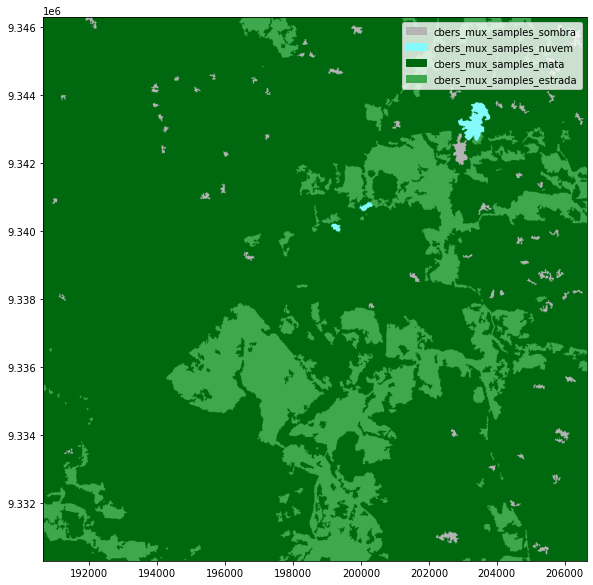

In [39]:
# Define a look up table (LUT) for the class names
# to be used to generate the legend for the map.
cls_names_lut = dict()
for cls_name in cls_smpls_fnl_info:
    cls_names_lut[cls_smpls_fnl_info[cls_name].out_id] = cls_name


# Get the image data using the get_gdal_thematic_raster_mpl_imshow function.
(
    img_data,
    img_coords,
    lgd_patches,
) = rsgislib.tools.plotting.get_gdal_thematic_raster_mpl_imshow(
    out_cls_img, out_patches=True, cls_names_lut=cls_names_lut
)

# Create the matplotlib figure
fig, ax = plt.subplots(figsize=(10, 10))

# Use the imshow function to display the image data within the plot
# the extent option defines the x and y axis values.
ax.imshow(img_data, extent=img_coords)

# Add the legend to the plot using the patches from the
# get_gdal_thematic_raster_mpl_imshow function.
ax.legend(handles=lgd_patches)

## 6.1 Visualise Subsets

Image Data Size: 1000 x 1000
Image Data Size: 1000 x 1000


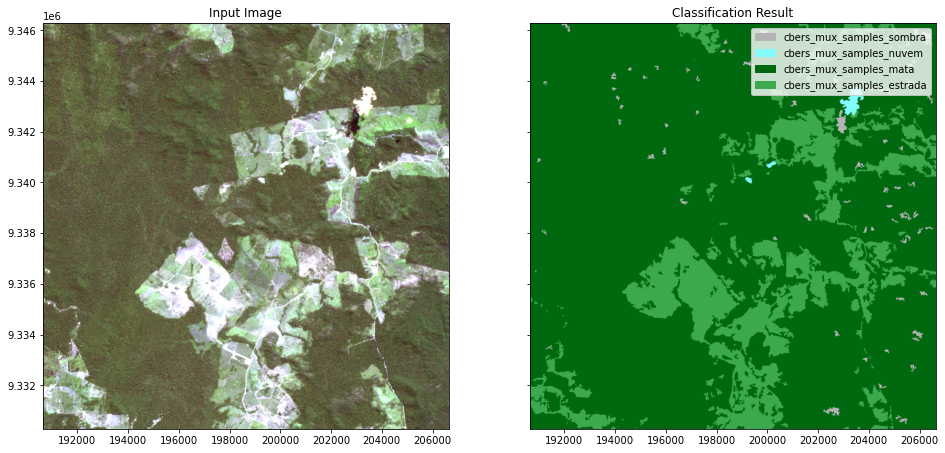

In [41]:
# Define a bbox for the subset to be displayed
sub_img_bbox = [190640.0000000000000000,9330288.0000000000000000,206640.0000000000000000,9346288.0000000000000000]

# Get the image data as a numpy array and the spatial bounding
# box of the image data. We have specified that the bands we
# want for the visualisation are 8, 9, 3 (NIR, SWIR1, Red)
# which produces a good false colour visualisation which is
# good at picking out vegetation. If you want a true colour
# (i.e., Red, Green, Blue) visualisation change the bands to
# [3, 2, 1]
img_s2_data, img_s2_coords = rsgislib.tools.plotting.get_gdal_raster_mpl_imshow(
    input_img, bands=[1, 2, 3], bbox=sub_img_bbox
)

# Stretch the image data so is visualises appropriately and usefully
# In this case the resulting values will be between 0-1.
img_s2_data_strch = rsgislib.tools.plotting.stdev_stretch_np_arr(
    img_s2_data, no_data_val=0.0
)


# Get the image data using the get_gdal_thematic_raster_mpl_imshow function.
(
    img_cls_data,
    img_cls_coords,
    lgd_patches,
) = rsgislib.tools.plotting.get_gdal_thematic_raster_mpl_imshow(
    out_cls_img, out_patches=True, cls_names_lut=cls_names_lut, bbox=sub_img_bbox
)


# Create the matplotlib figure - in this case two plots so the NDVI
# and image are plotted alongside each other
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), sharey=True)

# Use the imshow function to display the image data within the plot
# the extent option defines the x and y axis values.
ax1.imshow(img_s2_data_strch, extent=img_s2_coords)
ax1.title.set_text("Input Image")
ax2.imshow(img_cls_data, extent=img_cls_coords)
ax2.title.set_text("Classification Result")
# Add the legend to the plot using the patches from the
# get_gdal_thematic_raster_mpl_imshow function.
ax2.legend(handles=lgd_patches)

How does this result compare to the one produced by classifying just the image pixels?

## Refereces:
  - https://github.com/remotesensinginfo/rsgislib-tutorials/blob/main/03_intro_image_classification/02_segment_ml_classification.ipynb